In [5]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP
from library import helpers, config

In [82]:

def load_scores_decod_tfr(sub_list_str, conditions, part_epo='fulllength', signaltype='collapsed'):
    """Load decoding results from disc.
    
    Parameters
    ----------
    conditions : list
        List of strings containing the classes of the classification. 
    part_epo : str, optional
        Part of the epoch. One of: 'fulllength', 'cue', 'stimon' (default is 'stimon').
    signaltype: str
        Processing state of the sensor signal. One of: 'collapsed': electrode positions flipped for cue left trials
                                                       'uncollapsed': normal electrode positions,
                                                       'difference': difference signal: contra minus ipsilateral
                                                       (default is 'collapsed'.)

    Returns
    -------
    results: ndarray 
        Array with decoding results (subjects x freqs x times)
    times: array, 1d
    freqs: array, 1d
    """
    if len(sub_list_str) > 1:
         sub_folder = '-'.join(sub_list_str[0], sub_list_str[-1])
    else:
         sub_folder = sub_list_str[0]

    contrast_str = '_vs_'.join(conditions)
    fpath = op.join(config.path_decod_tfr, 'wavelet', part_epo, signaltype, contrast_str, sub_folder, 'scores')
    fname = op.join(fpath, 'scores_per_sub.npy')
    res = np.load(fname)
    times = np.load(fname[:-4] + '__times.npy')
    freqs = np.load(fname[:-4] + '__freqs.npy')
    return(res, times, freqs)


def get_freq_indices(freqs_of_interest, freqs_decoded, tfr_analysis='wavelet'):
    """Get indices of the relevant frequencies. 

    Parameters
    ----------
    freqs_of_interest : list, tuple
        Specify freqs of interest as list, tuple or list of tuples:
        (8,13): include all freqs between 8 and 13
        [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
    freqs_decoded : list
        nested list, specifying the freq windows that have been used for decoding. 
        Best to use the output of the decoding function or load it from disc.
    tfr_analysis : str
        Which analysis was run? Either "csp" or "wavelet"
 

    Returns
    -------
    list
        list of indices into freqs_decoded
    """
    indices = list()
    
    if not isinstance(freqs_of_interest, list):
        freqs_of_interest = [freqs_of_interest]
    
    if tfr_analysis == 'csp':
        for f_oi in freqs_of_interest:
            if isinstance(f_oi, tuple):
                f_oi = np.sort(f_oi)
                for idx, freq in enumerate(freqs_decoded):
                    if((freq[0] == f_oi[0]) or (freq[-1] == f_oi[-1])):
                        indices.append(idx)
                    elif ((freq[0] < f_oi[0] < freq[-1]) or (freq[0] < f_oi[-1] < freq[-1])): 
                        indices.append(idx)
                    elif ((f_oi[0] < freq[0]) and (f_oi[-1] > freq[-1])):
                        indices.append(idx)
            else:
                for idx, freq in enumerate(freqs_decoded):
                    if ((f_oi >= freq[0]) and (f_oi <= freq[1])):
                        indices.append(idx)
        
        
    elif tfr_analysis == 'wavelet':
        for f_oi in freqs_of_interest:
            if isinstance(f_oi, tuple):
                f_oi = np.sort(f_oi)
                for idx, freq in enumerate(freqs_decoded):
                    if((freq >= f_oi[0]) and (freq <= f_oi[-1])):
                        indices.append(idx)
            else:
                for freq in enumerate(freqs_decoded):
                    if (freq == f_oi):
                        indices.append(idx)
    
    indices = np.unique(indices)
    return(indices)


def plot_decod_image_tfr(scores, conditions, times, freqs, tfr_analysis='wavelet', ax=None):
    """Plot a heatmap with decoding accuracy over time and frequency. 
    
    Parameters
    ----------
    scores : ndarray, 2d
        2d array with decoding results (freqs x timepoints)
    conditions : list
        List of strings containing the classes of the classification. 
    times: array, 1d
        Timepoints
    freqs : array, 1d
        Frequencies 
    tfr_analysis : str
        Which analysis was run? Either "csp" or "wavelet"
    ax : axis, optional
        Axis to plot into.

    Returns
    -------
    image
        AxisImage
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    dx = np.diff(times)[0] / 2
    if tfr_analysis == 'csp':
        yticks = [f for frange in freqs for f in frange]
        dy = 0 #np.diff(freqs)[0] / 2
    elif tfr_analysis == 'wavelet':
        yticks = freqs[::2]
        dy = np.diff(freqs)[0] / 2
    else:
        raise ValueError(f'Invalid tfr_analysis: {tfr_analysis}')

    extent = [times.min()-dx, times.max()+dx,
              freqs.min()-dy, freqs.max()+dy]             
    image = ax.imshow(scores, origin='lower', cmap='Greens', aspect='auto', extent=extent)
    ax.set_yticks(yticks)    
    ax.set_ylabel('frequency (Hz)')
    return(image)


def plot_score_ts(scores_df, plt_dict, color, ax=None, n_boot=1000):
    """Plot the decoding scores as timeseries line plot.
    
    Parameters
    ----------
    scores_df : DataFrame 
        Data frame containing accuracies per time point in epoch. Long format. 
        Needed columns: 'time',
                        'score'
    plt_dict: dict
        Dict containing info relevant for plotting. 
        Entries needed: 't_stimon': relative time of stimulus onset
                        'xmin': minimal time to be plotted
                        'xmax': maximal time to be plotted
    color: str
        A single color string referred to by name, RGB or RGBA code,
        for instance ‘red’ or ‘#a98d19’.    
    ax: axis, optional
        Axis to plot into.
    n_boot: int
        Number of bootstrapping iterations for the CI.

    Returns
    -------
    image
        AxisImage
    
    """
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    image = sns.lineplot(x='time', 
                 y='score', 
                 color = color,
                 data=scores_df, 
                 n_boot=n_boot,  
                 ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(plt_dict['xmin'], plt_dict['xmax']), ylim=ytick_range)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('Time (s)')
    ax.axvspan(plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, color='grey', alpha=0.3)
    ax.axvspan(plt_dict['t_stimon']+ 2.2, plt_dict['t_stimon'] + 2.5, color='grey', alpha=0.3)
    ax.vlines((plt_dict['t_stimon'], plt_dict['t_stimon']+0.2, plt_dict['t_stimon']+2.2),
              ymin=ytick_range[0], ymax=ytick_range[1], 
              linestyles='dashed')
    ax.hlines(0.5, xmin=plt_dict['xmin'], xmax=plt_dict['xmax'])
    return(image)


Text(0.5, 0.5, 'avg. over\nfrequencies:\n10\n12\n14')

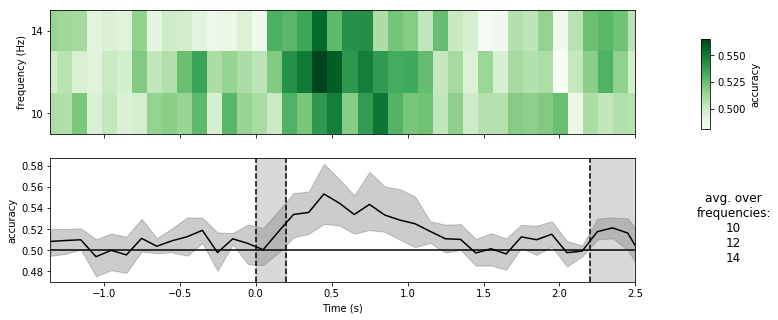

In [102]:
conditions = ['EccS', 'EccL'] #['EccS', 'EccL']

sub_list = np.setdiff1d(np.arange(1, 8), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

scores_list = list()
for subID in sub_list_str:
    scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions)
    scores_list.append(scores_sub)

scores = np.concatenate(scores_list)

%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 5]

# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = (10,14)
# translate freqs_of_interest to index:
idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs, 'wavelet')


# Setup dict with infos for plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0],
      'xmax': times[-1]}
plt_dict['stimon'] = pp


fig, ax = plt.subplots(2,1, sharex=True)

scores_avg = np.mean(scores, axis=0)
im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, 'wavelet', ax[0])

acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
acc_df.columns = times
acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'


plot_score_ts(acc_df_long, plt_dict['stimon'], color='black', ax=ax[1])
fig.subplots_adjust(right=0.75)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax, label='accuracy')
txt_ax = fig.add_axes([0.85, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequencies:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)


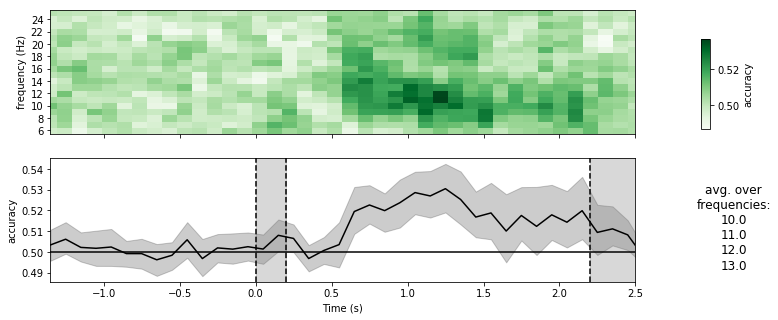

In [90]:
conditions = ['LoadLow', 'LoadHigh'] #['EccS', 'EccL']

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

scores_list = list()
for subID in sub_list_str:
    scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions)
    scores_list.append(scores_sub)

scores = np.concatenate(scores_list)


# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = (10,13)
# translate freqs_of_interest to index:
idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs, 'wavelet')


# Setup dict with infos for plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0],
      'xmax': times[-1]}
plt_dict['stimon'] = pp


fig, ax = plt.subplots(2,1, sharex=True)

scores_avg = np.mean(scores, axis=0)
im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, 'wavelet', ax[0])

acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
acc_df.columns = times
acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'


plot_score_ts(acc_df_long, plt_dict['stimon'], color='black', ax=ax[1])
fig.subplots_adjust(right=0.75)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax, label='accuracy')
txt_ax = fig.add_axes([0.85, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequencies:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)
plt.rcParams['figure.figsize'] = [13, 5]

In [98]:
'\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])

'[ 8. 10.]\n[10. 12.]\n[12. 14.]'

FileNotFoundError: [Errno 2] No such file or directory: '/draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/10_tfr_decoding/wavelet/fulllength/collapsed/LoadLowEccS_vs_LoadHighEccS/VME_S08/scores/scores_per_sub.npy'

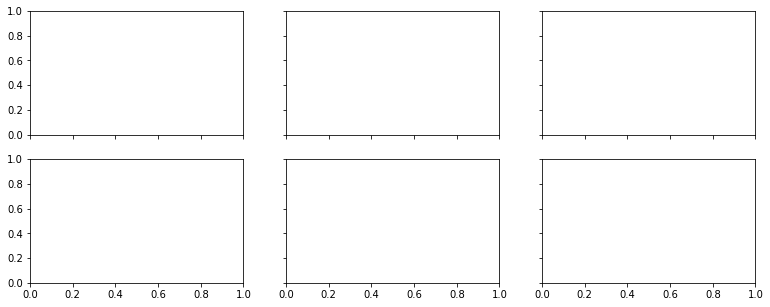

In [107]:
            
            
freqs_of_interest = (10, 13)
# translate freqs_of_interest to index:
idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs)



plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0]-0.25,
      'xmax': times[-1]+0.25}
plt_dict['stimon'] = pp


fig, axx = plt.subplots(2,3, sharex=True, sharey='row')

for i, ecc in enumerate(['S', 'M', 'L']):
    conditions = ['LoadLowEcc' + ecc, 'LoadHighEcc' + ecc]

    sub_list = np.setdiff1d(np.arange(1, 14), config.ids_missing_subjects +
                            config.ids_excluded_subjects)               
    sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

    scores_list = list()
    for subID in sub_list_str:
        scores_sub, times, freqs = load_scores_decod_tfr([subID], conditions)
        scores_list.append(scores_sub)

    scores = np.concatenate(scores_list)
    
    # Plot heatmap (freqs x times):
    scores_avg = np.mean(scores, axis=0) # average across subjects
    im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, 'wavelet', axx[0,i])
    
    # Plot time series (averaged across frequencies of interest)
    if not isinstance(idx_freqs_of_intr, list): 
        idx_freqs_oi = [idx_freqs_of_intr]
    acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
    acc_df.columns = times
    acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
    acc_df_long['decoding target'] = 'Load'
    plot_score_ts(acc_df_long, plt_dict['stimon'], config.colors['Ecc'+ecc], axx[1,i], 1000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax)
txt_ax = fig.add_axes([0.85, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequencies:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)
    
plt.rcParams['figure.figsize'] = [13, 5]

In [47]:
times

array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
        2.  ])

In [54]:
tmin = -0.5
tmax = 2.5
window_spacing = 0.25
w_size = 0.5
w_overlap = 0.5
step_size = w_size * (1 - w_overlap)
centered_w_times = np.arange(tmin + (w_size / 2.), tmax - (w_size / 2), step_size)
centered_w_times

array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
        2.  ])

In [ ]:
conditions = ['EccS', 'EccL']
scores, times, freqs = load_scores_decod_tfr(conditions)

# Specify freqs of interest as list, tuple or list of tuples:
# (8,13): include all freq between 8 and 13
# [8, 13]: include all freq windows that entail either 8 or 13 (but not 9-11 for example)
freqs_of_interest = (10,13)
# translate freqs_of_interest to index:
idx_freqs_of_intr = get_freq_indices(freqs_of_interest, freqs)


# Setup dict with infos for plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': times[0],
      'xmax': times[-1]}
plt_dict['stimon'] = pp


fig, ax = plt.subplots(2,1, sharex=True)

scores_avg = np.mean(scores, axis=0)
im = plot_decod_image_tfr(scores_avg, conditions, times, freqs, ax[0])

acc_df = pd.DataFrame(scores[:, idx_freqs_of_intr, :].mean(axis=1)) #average across freqs of interest
acc_df.columns = times
acc_df_long = acc_df.melt(var_name='time', value_name='score')  # put into long format
acc_df_long['decoding target'] = 'Load'


plot_score_ts(acc_df_long, plt_dict['stimon'], color='black', ax=ax[1])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.55, 0.01, 0.25])
fig.colorbar(im, cax=cbar_ax, label='accuracy')
txt_ax = fig.add_axes([0.85, 0.15, 0.01, 0.25])
txt_ax.set_axis_off()
freqs_formatted = '\n'.join([str(f) for f in freqs[idx_freqs_of_intr]])
txt_ax.text(0.5*(1), 0.5*(1), f'avg. over\nfrequency\nbands:\n{freqs_formatted}',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=txt_ax.transAxes)